
# Model building hierarchy



First, let's get some data ([https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd11.htm#pt.r1](https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd11.htm#pt.r1)). This data is measured pressure of a fixed amount of a gas in a tank as a function of pressure. We will look at various approaches to building a model from this data.



In [1]:
import os
import urllib.request
url = 'https://www.itl.nist.gov/div898/handbook/datasets/MODEL-4_4_4.DAT'
fname = 'MODEL-4_4_4.DAT'
if not os.path.exists(fname):
    filename, headers = urllib.request.urlretrieve(url, fname)

Now, let's read it in. First we inspect the first couple of lines. This indicates what columns the data is in, and that we should skip the first two lines to get to the data.



In [1]:
with open('MODEL-4_4_4.DAT') as f:
    for i in range(3):
        print(f.readline().strip())

Run          Ambient                            Fitted
Order  Day  Temperature  Temperature  Pressure    Value    Residual
1      1      23.820      54.749      225.066   222.920     2.146

We want the Temperature and Pressure data in columns 3 and 4. We plot it here to see how it looks.



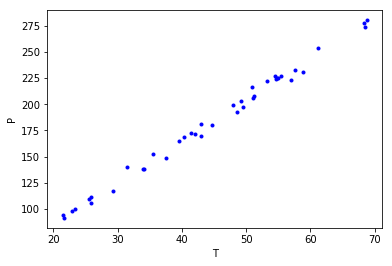

In [1]:
import numpy as np
data = np.loadtxt('MODEL-4_4_4.DAT', skiprows=2)
T = data[:, 3]
P = data[:, 4]

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(T, P, 'b.')
plt.xlabel('T')
plt.ylabel('P')

If we assume the ideal gas law, we expect we could fit a line $P = nR/V T$ in this range. This is a physically motivated law, but do we expect it to work at high P? Probably not, there could be *nonideal* interactions at high pressure that are negligible in low pressure regimes. In other words, the ideal gas model is the *wrong model* for those conditions.




## polyfit



Here we fit a polynomial through the data. That polynomial could be a line, perhaps in this case motivated by $PV = nRT$.



[ 3.93014044  7.74899739]

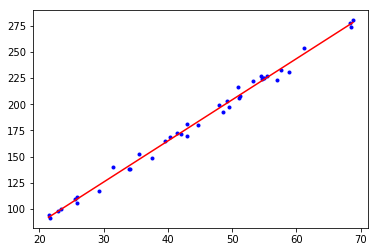

In [1]:
Tfit = np.linspace(T.min(), T.max())

p = np.polyfit(T, P, 1)
print(p)
fit = np.polyval(p, Tfit)
plt.plot(T, P, 'b.', Tfit, fit, 'r-');

This is simple, and you only need to decide what order polynomial to choose. This data set is straightforward in this case.




## interp1d



Interpolation turns out to be not that useful for this data, because it is so noisy. The interpolation is too local/short-ranged to provide much smoothing.



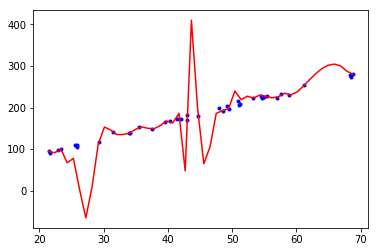

In [1]:
from scipy.interpolate import interp1d

model = interp1d(T, P, kind='cubic')

Tfit = np.linspace(T.min(), T.max())
plt.plot(T, P, 'b.', Tfit, model(Tfit), 'r-')

**Exercise** Try different kinds of interpolation, 'linear', and 'quadratic' for example. Some are better than others, but none of them provide significant smoothing.




## linear regression



Suppose we believe the model to be $P = a / T + b ln(T) + c T$. We have a linear model, and can solve it with `np.linalg.lstsq`, or you can do the matrix algebra of the normal equation to get the parameters.



[ 86.69500473   1.1563442    3.958102  ]


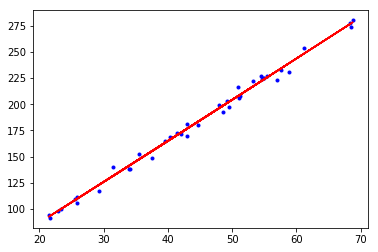

In [1]:
X = np.array([1 / T,
              np.log(T),
              T]).T

pars, resid, rank, s = np.linalg.lstsq(X, P)
print(pars)

plt.plot(T, P, 'b.', T, X @ pars, 'r-')

This is more flexible than polyfit because you can include non-polynomial functions.




## curve\_fit



If you suspect a nonlinear model, then we use curve\_fit or least\_squares. Here we have to define a model, and provide an initial guess. Say we think the model is $P = a T^b$.



[ 4.87807943  0.954995  ]


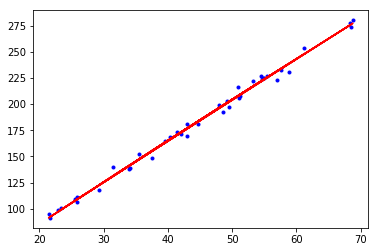

In [1]:
from scipy.optimize import curve_fit

def model(x, a, b):
    return a * x ** b

p0 =  [0, 1]
popt, pcov = curve_fit(model, T, P, p0)
print(popt)
plt.plot(T, P, 'b.', T, model(T, *popt), 'r-')

You can see that b is practically one, suggesting a linear model was ok after all.




## neural network



Finally, if we have no idea what the model should look like, and see interpolation has failed, but we want a model anyway, we can resort to a neural network. This turned out to be subtle. It is about 50-50 that we get a solution that is reasonable, and it all depends on the initialization of the guess.



`ftol` termination condition is satisfied. 351.162777128 [-0.00388658 -0.35416423 -0.40450101 -0.00837795  0.          0.          0.
1. 0.          0.        ]


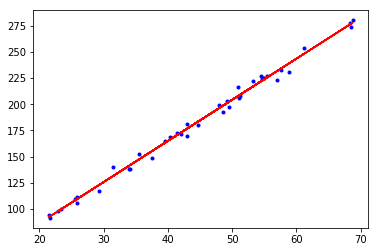

In [1]:
import autograd.numpy as np
from autograd import jacobian

from scipy.optimize import least_squares

def relu(x):
    return x * (x > 0)

def model(x, *pars):
    b1, w10, w00, b00, w11, w01, b01, w12, w02, b02 = pars
    pred = (b1 + w10 * relu(w00 * x + b00)
               + w11 * relu(w01 * x + b01)
               + w12 * relu(w02 * x + b02))
    return pred


def resid(pars):
    return P - model(T, *pars)

pars = least_squares(resid, x0=np.random.randn(10) * 0.1)
print(pars.message, pars.cost, pars.grad)
plt.plot(T, P, 'b.', T, model(T, *pars.x), 'r-')

\#+END\_SRC

It is extreme overkill in this example to use a neural network, because a line looks so obvious.




# elementwise\_grad vs grad



This question is about when to use grad and when to use elementwise\_grad.

1.  If you have a scalar function that takes a scalar argument, and you expect the derivative to be a scalar output, then use `grad`.



In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad

def f(x):
    return x**2

gf = grad(f)

gf(2.0)

4.0

Our function is *vectorized*.



In [1]:
X = np.linspace(0, 1, 5)
f(X)

array([ 0.    ,  0.0625,  0.25  ,  0.5625,  1.    ])

`grad` is *not* vectorized.



In [1]:
gf(X)

TypeErrorTraceback (most recent call last)
<ipython-input-7-eb1c15c461ad> in <module>()
----> 1 gf(X)

~/anaconda/lib/python3.6/site-packages/autograd/wrap_util.py in nary_f(*args, **kwargs)
     18             else:
     19                 x = tuple(args[i] for i in argnum)
---> 20             return unary_operator(unary_f, x, *nary_op_args, **nary_op_kwargs)
     21         return nary_f
     22     return nary_operator

~/anaconda/lib/python3.6/site-packages/autograd/differential_operators.py in grad(fun, x)
     24     vjp, ans = _make_vjp(fun, x)
     25     if not vspace(ans).size == 1:
---> 26         raise TypeError("Grad only applies to real scalar-output functions. "
     27                         "Try jacobian or elementwise_grad.")
     28     return vjp(vspace(ans).ones())

TypeError: Grad only applies to real scalar-output functions. Try jacobian or elementwise_grad.

You have two options here. The first is to get the gradients one element at a time.



In [1]:
[gf(_x) for _x in X]

[0.0, 0.5, 1.0, 1.5, 2.0]

The second is to use elementwise\_grad which interprets this to mean that each row/element in the input is an independent input, essentially doing the iteration above.



In [1]:
??elementwise_grad

`elementwise_grad` *acts* vectorized.



In [1]:
egf = elementwise_grad(f)
egf(X)

array([ 0. ,  0.5,  1. ,  1.5,  2. ])

Oh, what about the jacobian? The diagonal of the jacobian is equivalent to elementwise\_grad, but you will do a lot of unnecessary computations on the off-diagonals to get this.



In [1]:
from autograd import jacobian

j = jacobian(f)
j(X)

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  2. ]])


## Can I always use elementwise\_grad?



I can't think of a reason why this isn't a good idea, but a double negative here doesn't imply it is a good idea! It seems to do the right thing in the examples I can come up with. There may be some performance reason to not do this, but not one that is observable here.



In [1]:
egf(2.0), gf(2.0)

(4.0, 4.0)

In [1]:
egf(np.array([2.0, 3.0]))

array([ 4.,  6.])

Here is a function that is not vectorized on argument A.



In [1]:
def g(x, A):
    a, b = A
    return a * x + b

f1 = grad(g, 1)
f1(1.0, [2.0, 3.0])

[array(1.0), array(1.0)]

In [1]:
ef1 = elementwise_grad(g, 1)
ef1(1.0, [2.0, 3.0])

[array(1.0), array(1.0)]

You cannot pass an array of A values though, and get derivatives for each one because the g function is not vectorized.

So, if your function is not vectorized, you cannot use elementwise\_grad. It takes some skill to vectorize this, but here is one example of doing that. This function can take an array of A values, and compute the output for each one. Then, we can use elementwise\_grad to get the derivatives dg/dA for each one.



In [1]:
def g(x, A):
    A = np.array(A)
    return A[:, 0] * x + A[:, 1]

g(1.0, [[2.0, 3.0],
        [3.0, 4.0]])

f1 = elementwise_grad(g, 1)
f1(1.0, [[2.0, 3.0],
        [3.0, 4.0]])

[[array(1.0), array(1.0)], [array(1.0), array(1.0)]]


# A different view of the neural network



One way to think of a neural network is a series of matrix operations.

Say our input has a shape like (N, 1), that is N rows in one column. Each layer is a matrix multiplication plus a bias vector. Lets neglect the bias vector for now, it is just an elementwise addition which does not affect the array shapes. We will also neglect the activation functions for now, they are just an elementwise operation that also does not affect the array shapes..

Next, suppose we want the first layer to have M1 neurons. Then, the matrix of weights will have a shape of (1, M1) so that we have input @ layer1\_weights (N, 1) @ (1, M1) which has an array with a shape of (N, M1) as the output. This output is then the input to the next layer. In our example, we want an output with a shape of (N, 1) which means one output for every input. That means the weights in the output layer must have a shape of (M1, 1) so that (N, M1) @ (M1, 1) is (N, 1).

So in the simplified form where we describe above, the neural network looks like

    y = (N, 1) @ (1, M1) @ (M1, 1)
        input    array1     array2

where array1 and array2 are the *weights* we have to find to make the neural network match our data.

Now, lets add in the biases and activations. We only activate the inner layer, so in this case we get:

    L1 = tanh((N, 1) @ (1, M1) + b1) = an array of shape (N, M1), and b1 is a vector with M1 elements that is added to each row
    L2 = L1 @ (M1, 1) + b2 = an array of shape(N, 1) and b2 is a vector with 1 element that is added to each row.

If we have many layers, say layer1 with M1 neurons, and layer2 with M2 neurons we have:

y = (N, 1) @ (1, M1) @ (M1, M2) @ (M2, 1) = (N, 1)

or

    L1 = tanh((N, 1) @ (1, M1) + b1)
    L2 = tanh(L1 @ (M1, M2) + b2)
    L3 = L2 @ (M2, 1) + b3  this is the output layer




# Final exam details



06623 A MTHML MDL CHM ENG PC Monday, December 10, 2018 01:00 p.m. - 04:00 p.m., WEH 7500

-   Cumulative exam
-   Expecting 6 problems
-   Make sure your laptop is fully charged at the beginning.

